<a href="https://colab.research.google.com/github/RRADJon/pyPBPK_dev/blob/main/pyPBPK_cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Cell 1: PBPK Model Definition and Explanation

#@markdown **PBPK Model Architecture, Assumptions, and Functions**

#@markdown
#@markdown Model Structure and Assumptions

#@markdown This PBPK model is a **full-PBPK model** structured into 16 compartments, all connected by systemic blood flow (perfusion-limited model).

#@markdown **Compartments:** 4 GI Lumen (Stomach, Duodenum, Jejunum, Ileum), 9 Tissues (Liver, Kidney, Muscle, Adipose, Brain, Rest, and 4 GI tissues), and 2 Blood (Arterial, Venous).

#@markdown **Perfusion-Limited:** The rate of drug uptake/release by tissues is limited by blood flow (assumes instantaneous drug diffusion between tissue and blood).</li>

#@markdown **Clearance:** Hepatic clearance is modeled using the **Well-Stirred Model** (or Parallel-Tube Model), which relates intrinsic clearance ($\text{CL}_{\text{int}}$) to effective hepatic clearance ($\text{CL}_{\text{H}}$) based on blood flow and plasma unbound fraction ($f_u$). Renal clearance is simple first-order elimination of unbound drug from the arterial blood.

#@markdown **Absorption:** Oral absorption is modeled by first-order rate constant ($KA$) or based on effective permeability ($\text{P}_{\text{eff}}$), with transit between the four GI segments.

#@markdown **Variability:** Inter-individual variability (Population Simulation) is introduced by sampling liver enzyme activity (CYPs) and scaling organ volumes/flows based on generalized population data (e.g., allometric scaling by weight).

#@markdown **Key Functions**

#@markdown **sample_physiology**

#@markdown Scales the base organ volumes/flows to the individual's weight/age and introduces random variability (not yet fully implemented with weight/age forms, but set up for variability).
#@markdown **sample_enzyme_activity**

#@markdown Generates individual enzyme activities (e.g., $\text{CYP}3\text{A}4$) using **Log-Normal distributions** to reflect inter-individual metabolic variation.

#@markdown **calculate_CLint_total**

#@markdown Sums $\text{CL}_{\text{int}}$ from different CYP enzymes, accounting for their contribution fractions and individual sampled activity.

#@markdown **pbpk_ode**

#@markdown The core function containing the 16 mass balance Ordinary Differential Equations. It calculates the instantaneous rate of change ($\text{dAmount}/\text{dt}$) in all compartments based on blood flow, partition coefficients ($\text{K}_{\text{p}}$), absorption ($KA$), and clearance ($\text{CL}_{\text{H}}$, $\text{CL}_{\text{renal}}$).

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.stats import lognorm
import copy

# --- 1. Global/Base Physiology Parameters ---
# ... (physiology_base, state_names, etc., remains unchanged) ...

# Base reference physiology (70kg adult)
physiology_base = {
    "cardiac_output": 420, # L/h
    "organs": {
        "liver":   {"V": 1.8, "Q_frac": 0.25, "Kp": 5.0},
        "kidney":  {"V": 0.3, "Q_frac": 0.20, "Kp": 3.0},
        "stomach": {"V": 0.5, "Q_frac": 0.03, "Kp": 2.0},
        "duodenum":{"V": 0.3, "Q_frac": 0.04, "Kp": 4.0},
        "jejunum": {"V": 0.6, "Q_frac": 0.05, "Kp": 4.5},
        "ileum":   {"V": 0.6, "Q_frac": 0.03, "Kp": 4.0},
        "muscle":  {"V": 29,  "Q_frac": 0.17, "Kp": 2.0},
        "adipose": {"V": 18,  "Q_frac": 0.05, "Kp": 20},
        "brain":   {"V": 1.4, "Q_frac": 0.08, "Kp": 1.0},
        "rest":    {"V": 15,  "Q_frac": None, "Kp": 2.5}
    },
    "blood": {"V_art": 1.5, "V_ven": 3.0}
}

# Define the order and index of the states
state_names = [
    "stomach_lumen", "duodenum_lumen", "jejunum_lumen", "ileum_lumen",
    "liver", "kidney", "stomach", "duodenum", "jejunum", "ileum",
    "muscle", "adipose", "brain", "rest", "arterial", "venous"
]
state_index = {name: i for i, name in enumerate(state_names)}
n_states = len(state_names)
GI_segments = ["stomach", "duodenum", "jejunum", "ileum"]

# Enzyme fractions (for CLint calculation)
enzyme_contributions = {
    "CYP3A4": 0.8,
    "CYP2D6": 0.15,
    "CYP2C9": 0.05
}

# --- 2. Physiological and Enzyme Sampling Functions ---
# ... (functions remain unchanged) ...

def sample_enzyme_activity():
# ... (code omitted for brevity) ...
    return {
        "CYP3A4": lognorm(s=0.25, scale=1).rvs(),
        "CYP2D6": lognorm(s=0.45, scale=1).rvs(),
        "CYP2C9": lognorm(s=0.30, scale=1).rvs()
    }

def calculate_CLint_total(drug, enzyme_activity):
# ... (code omitted for brevity) ...
    CL_int_total = 0.0
    for enz, frac in enzyme_contributions.items():
        CLint = drug["CLint"].get(enz, 0.0) # CLint is in µL/min/mg protein
        CL_int_total += frac * CLint * enzyme_activity.get(enz, 1.0)
    return CL_int_total

def sample_physiology(base_physiology, drug, age=35, weight=70):
# ... (code omitted for brevity) ...
    phys = {"age": age, "weight": weight}

    # Cardiac Output scaling (allometric)
    CO_base = base_physiology["cardiac_output"]
    phys["cardiac_output"] = CO_base * (weight / 70) ** 0.75

    # Liver blood flow age correction
    age_factor = max(0.7, 1 - 0.005 * max(age - 30, 0))

    phys["blood"] = base_physiology["blood"].copy()
    phys["organs"] = {}

    total_frac = 0
    sampled_fracs = {}

    for organ, props in base_physiology["organs"].items():
        phys["organs"][organ] = props.copy()
        phys["organs"][organ]["V"] *= (weight / 70)

        if props.get("Q_frac") is not None:
            frac = props["Q_frac"]
            if organ == "liver":
                frac *= age_factor
            sampled_fracs[organ] = frac
            total_frac += frac

    # Normalize flows to cardiac output
    for organ, frac in sampled_fracs.items():
        phys["organs"][organ]["Q"] = phys["cardiac_output"] * frac / total_frac

    # Rest compartment flow
    phys["organs"]["rest"]["Q"] = phys["cardiac_output"] - sum(
        phys["organs"][o]["Q"] for o in sampled_fracs
    )
    return phys

def calculate_KA_from_Permeability(P_eff_cm_min, V_gut_L):
    """
    Calculates the absorption rate constant (KA in 1/h) from P_eff.
    """
    S_V_factor = 10 # 1/cm - Simplified gut surface area to volume ratio
    KA = P_eff_cm_min * S_V_factor * 60
    return KA

def renal_clearance_Amount_h(C_art, drug):
    """
    Renal Clearance (Amount/h) - Sink from Arterial compartment.
    """
    fu_plasma = drug["fu_plasma"]
    CL_renal_unbound = drug["CL_renal"] # L/h
    Rate_elim = CL_renal_unbound * C_art * fu_plasma
    return Rate_elim

def calculate_CL_H_eff(drug, physiology, enzyme_activity):
    """
    Calculates the total effective hepatic clearance (L/h) using the well-stirred model.
    """
    CL_int_mic = calculate_CLint_total(drug, enzyme_activity)

    # Robust CLint to L/h conversion (Copied from the ODE for consistency)
    if "physchem" in drug and "MPPGL" in drug["physchem"]:
        MPPGL = drug["physchem"].get("MPPGL", 40)
        Liver_Weight = drug["physchem"].get("liver_weight", 1500)
        scaling_factor = (MPPGL * Liver_Weight / 1000) * (60 / 1000000)
        CL_int_total_L_h = CL_int_mic * scaling_factor
    else:
        CL_int_total_L_h = CL_int_mic

    fu = drug["fu_plasma"]
    Qh = physiology["organs"]["liver"]["Q"]

    # Well-Stirred Extraction Ratio (E)
    E = (fu * CL_int_total_L_h) / (Qh + fu * CL_int_total_L_h)

    # Effective Hepatic Clearance (CL_H)
    CL_H = Qh * E
    return CL_H, E

# --- 3. PBPK ODE (Core Model) ---

def pbpk_ode(t, y, physiology, drug, enzyme_activity):
# ... (ODE code remains unchanged) ...

    dydt = np.zeros_like(y)

    C_art = y[state_index["arterial"]] / physiology["blood"]["V_art"]
    C_ven = y[state_index["venous"]] / physiology["blood"]["V_ven"]

    Q_H_art = physiology["organs"]["liver"]["Q"]
    Q_H_total = Q_H_art + sum(physiology["organs"][o]["Q"] for o in GI_segments)

    portal_flow_to_liver_mass = 0.0
    venous_return = 0.0

    # --- Clearance Pre-calculation (Robust Fix) ---
    CL_int_mic = calculate_CLint_total(drug, enzyme_activity)
    fu_plasma = drug["fu_plasma"]

    # Robust check for CLint scaling (µL/min/mg protein to L/h)
    if "physchem" in drug and "MPPGL" in drug["physchem"]:
        MPPGL = drug["physchem"].get("MPPGL", 40)
        Liver_Weight = drug["physchem"].get("liver_weight", 1500)
        scaling_factor = (MPPGL * Liver_Weight / 1000) * (60 / 1000000)
        CL_int_total_L_h = CL_int_mic * scaling_factor
    else:
        # Assume CL_int is already scaled to L/h for drugs without physchem
        CL_int_total_L_h = CL_int_mic

    # --- 1. Luminal Transit and Absorption ---
    T_rate_stomach = 0.2  # Slow gastric emptying (h^-1)
    T_rate_intestine = 2.0 # Fast intestinal transit (h^-1)

    for i, segment in enumerate(GI_segments):
        lumen_i = state_index[segment + "_lumen"]
        tissue_i = state_index[segment]

        V_tissue = physiology["organs"][segment]["V"]
        Q_tissue = physiology["organs"][segment]["Q"]
        Kp_tissue = physiology["organs"][segment]["Kp"]

        # Absorption Rate
        # Apply bioavailability factor (PK-Sim compatible)
        F = drug.get("physchem", {}).get("F", 1.0)
        absorption_rate = F * drug["KA"] * y[lumen_i]

        # 1b. Luminal ODE
        if i == 0: # Stomach
            lumen_inflow = 0.0
            lumen_outflow = T_rate_stomach * y[lumen_i]
        else: # Intestine (Duodenum, Jejunum, Ileum)
            prev_segment = GI_segments[i-1]
            prev_lumen_i = state_index[prev_segment + "_lumen"]

            # Inflow is Outflow from previous segment
            transit_rate = T_rate_stomach if i == 1 else T_rate_intestine
            lumen_inflow = transit_rate * y[prev_lumen_i]

            lumen_outflow = T_rate_intestine * y[lumen_i]

        dydt[lumen_i] = lumen_inflow - absorption_rate - lumen_outflow

        # 1c. GI Tissue ODE
        C_org = y[tissue_i] / V_tissue
        C_ven_org = C_org / Kp_tissue

        # Mass transfer via Perfusion (In - Out)
        perfusion_mass_change = Q_tissue * (C_art - C_ven_org)

        # ODE: Absorption + Perfusion Mass Change
        dydt[tissue_i] = absorption_rate + perfusion_mass_change

        # GI Outflow (to Portal Vein)
        portal_flow_to_liver_mass += Q_tissue * C_ven_org

    # --- 2. Organ Perfusion and Clearance (Non-GI) ---
    non_gi_organs = [o for o in physiology["organs"] if o not in GI_segments]

    for organ in non_gi_organs:
        props = physiology["organs"][organ]
        i = state_index[organ]
        V = props["V"]
        Q = props["Q"]
        Kp = props["Kp"]

        C_org = y[i] / V
        C_ven_org = C_org / Kp # Whole blood concentration leaving organ

        inflow_outflow = Q * (C_art - C_ven_org)

        if organ == "liver":
            # Liver Mass Balance
            Liver_In = (Q_H_art * C_art) + portal_flow_to_liver_mass
            Liver_Out = Q_H_total * C_ven_org

            # Elimination Rate (Amount/h) = CL_int_total_L_h * C_unbound_liver_plasma
            C_unbound_liver = C_org / Kp * fu_plasma
            elim_rate_h = CL_int_total_L_h * C_unbound_liver

            dydt[i] = Liver_In - Liver_Out - elim_rate_h

            venous_return += Liver_Out

        else: # All other organs (kidney, muscle, adipose, brain, rest)
            dydt[i] = inflow_outflow
            venous_return += Q * C_ven_org

    # 3. Renal Clearance: Sink from the Arterial Compartment
    elim_renal = renal_clearance_Amount_h(C_art, drug)

    # 4. Central Compartments (Systemic Blood)
    dydt[state_index["venous"]] = venous_return - physiology["cardiac_output"] * C_ven
    dydt[state_index["arterial"]] = physiology["cardiac_output"] * (C_ven - C_art) - elim_renal

    return dydt

# --- 4. Main Execution Function (FIX APPLIED HERE) ---

def run_and_evaluate_pbpk(drug_params, physiology_base, t_eval, n_individuals=200):
    """ Runs single-individual and population PBPK simulations and extracts key metrics. """

    # Get the t_end dynamically from the t_eval array
    t_end_dynamic = t_eval[-1]

    single_enzyme_activity_ref = {"CYP3A4": 1.0, "CYP2D6": 1.0, "CYP2C9": 1.0}
    drug_params_mech = copy.deepcopy(drug_params)

    # Calculate KA from P_eff if available
    if "physchem" in drug_params_mech and "P_eff_transcellular" in drug_params_mech["physchem"]:
        P_eff = drug_params_mech["physchem"]["P_eff_transcellular"]
        V_gut_total = sum(physiology_base["organs"][seg]["V"] for seg in GI_segments)
        drug_params_mech["KA"] = calculate_KA_from_Permeability(P_eff, V_gut_total)

    # --- 1. Single-Individual Simulation ---
    drug = drug_params_mech
    physiology_single = sample_physiology(physiology_base, drug)

    y0 = np.zeros(n_states)
    dose = drug.get("dose_mg", 100)
    if drug["route"] == "oral":
        y0[state_index["stomach_lumen"]] = dose
    elif drug["route"] == "iv":
        y0[state_index["venous"]] = dose

    # FIX: Use [0, t_end_dynamic] for t_span
    sol = solve_ivp(
        pbpk_ode, [0, t_end_dynamic], y0, t_eval=t_eval,
        args=(physiology_single, drug, single_enzyme_activity_ref), method="LSODA"
    )

    C_art_single = sol.y[state_index["arterial"]] / physiology_single["blood"]["V_art"]

    # Handle the case where Cmax is near zero
    if np.max(C_art_single) < 1e-12:
         total_AUC_single = 0
         CL_total_single = np.inf
         Tmax_single = 0
         CL_H_eff_single = 0
         Hepatic_E_single = 0
    else:
        total_AUC_single = np.trapz(C_art_single, t_eval)
        CL_total_single = dose / total_AUC_single
        Tmax_single = t_eval[np.argmax(C_art_single)]
        CL_H_eff_single, Hepatic_E_single = calculate_CL_H_eff(drug, physiology_single, single_enzyme_activity_ref)

    single_results = {
        "Drug": drug["name"],
        "Simulation Type": "Single Individual",
        "KA (1/h) Used": drug["KA"],
        "Plasma Cmax (mg/L)": np.max(C_art_single),
        "Plasma AUC (mg*h/L)": total_AUC_single,
        "CL_total (L/h)": CL_total_single,
        "CL_H_eff (L/h)": CL_H_eff_single,
        "Tmax (h)": Tmax_single,
        "Hepatic Extraction Ratio": Hepatic_E_single
    }

    # --- 2. Population Simulation (COLLECTION REVISED) ---

    Cmax_list, AUC_list, CL_H_eff_list, Tmax_list = [], [], [], []
    plasma_profiles_list = []

    for _ in range(n_individuals):
        phys_i = sample_physiology(physiology_base, drug_params_mech)
        enzyme_activity_i = sample_enzyme_activity()

        y0_i = np.zeros(n_states)
        if drug["route"] == "oral":
            y0_i[state_index["stomach_lumen"]] = dose
        elif drug["route"] == "iv":
            y0_i[state_index["venous"]] = dose

        # FIX: Use [0, t_end_dynamic] for t_span
        sol_pop = solve_ivp(
            pbpk_ode, [0, t_end_dynamic], y0_i, t_eval=t_eval,
            args=(phys_i, drug_params_mech, enzyme_activity_i), method="LSODA"
        )
        plasma_C = sol_pop.y[state_index["arterial"]] / phys_i["blood"]["V_art"]

        if np.max(plasma_C) > 1e-12:
            Cmax_list.append(np.max(plasma_C))
            AUC_list.append(np.trapz(plasma_C, t_eval))
            Tmax_list.append(t_eval[np.argmax(plasma_C)])
            CL_H_eff_i, _ = calculate_CL_H_eff(drug, phys_i, enzyme_activity_i)
            CL_H_eff_list.append(CL_H_eff_i)

            plasma_profiles_list.append(plasma_C)

    # Convert list of vectors to a 2D array (Individuals x Time)
    pop_profiles_2d = np.array(plasma_profiles_list)

    Cmax_pop = np.array(Cmax_list)
    AUC_pop = np.array(AUC_list)
    CL_total_pop = dose / AUC_pop if len(AUC_pop) > 0 and (AUC_pop > 1e-12).any() else np.array([])

    # --- Calculate Geometric Mean and GCV% ---
    def calculate_geometric_stats(data):
        data = data[data > 1e-12]
        if data.size == 0:
            return np.nan, np.nan
        log_data = np.log(data)
        geom_mean = np.exp(np.mean(log_data))
        geom_sd = np.sqrt(np.exp(np.std(log_data, ddof=1)**2) - 1)
        gcv_percent = geom_sd * 100
        return geom_mean, gcv_percent

    Cmax_GM, Cmax_GCV = calculate_geometric_stats(Cmax_pop)
    AUC_GM, AUC_GCV = calculate_geometric_stats(AUC_pop)
    CL_total_GM, CL_total_GCV = calculate_geometric_stats(CL_total_pop)

    # --- Consolidate Report ---
    report = []

    # Population Median/CI
    report.append({
        "Drug": drug["name"], "Type": "Population Median",
        "Cmax (mg/L)": np.percentile(Cmax_pop, 50) if Cmax_pop.size > 0 else 0,
        "AUC (mg*h/L)": np.percentile(AUC_pop, 50) if AUC_pop.size > 0 else 0,
        "CL_total (L/h)": np.percentile(CL_total_pop, 50) if CL_total_pop.size > 0 else np.inf,
        "Tmax (h)": np.percentile(Tmax_list, 50) if Tmax_list else np.nan,
        "Hepatic Ext. Ratio": np.nan,
        "90% CI/GCV%": f"CI: [{np.percentile(Cmax_pop, 5):.2f}-{np.percentile(Cmax_pop, 95):.2f}]" if Cmax_pop.size > 0 else "CI: [0.00-0.00]",
    })

    # Population Variability
    report.append({
        "Drug": drug["name"], "Type": "Population Variability",
        "Cmax (mg/L)": Cmax_GM, "AUC (mg*h/L)": AUC_GM,
        "CL_total (L/h)": CL_total_GM, "Tmax (h)": np.nan,
        "Hepatic Ext. Ratio": np.nan,
        "90% CI/GCV%": f"GCV%: {Cmax_GCV:.2f}",
    })

    return single_results, pd.DataFrame(report), Cmax_pop, AUC_pop, t_eval, pop_profiles_2d, C_art_single

In [23]:
#@title Cell 2: 💊 Drug Input and Simulation Parameters (Colab Forms with Explanations)


# --- 1. Simulation Controls ---
#@markdown **⚙️Simulation Setup**

#@markdown **Number of Individuals:** The size of the simulated patient population ($N$). Higher $N$ leads to smoother population curves but takes longer to run.
n_pop_indiv = 60 #@param {type:"slider", min:10, max:500, step:10}
#@markdown **Simulation Time ($t_{end}$ in h):** The total duration of the PK simulation.
t_end = 96 #@param {type:"slider", min:12, max:168, step:12}
n_points = 500
t_eval = np.linspace(0, t_end, n_points)


# --- PK-Sim–Style Drug Inputs ---

#@markdown **Drug Properties:** input phyisical pharmacological properties for the drug
# --- 2. Drug Properties (The New Drug) ---
Drug_Name = "Alfentanil" #@param {type:"string"}
#@markdown Route/Dose: Defines how the drug enters the system (Oral: Stomach Lumen; IV: Venous Blood).
Route_of_Administration = "oral" #@param ["oral", "iv"]
Dose_mg = 100 #@param {type:"number", min:1, max:1000}


# === PK-Sim PhysChem Inputs ===
# Solubility at reference pH
Solubility_mg_per_mL = 0.034  #@param {type:"number"}
Reference_pH = 7.4 #@param {type:"number"}
#@markdown logP (octanol/water)
Lipophilicity_logP = 2.2  #@param {type:"number"}

Molecular_Weight_g_per_mol = 416.5 #@param {type:"number"}
Is_Small_Molecule = True #@param {type:"boolean"}


# === PK-Sim Binding ===
#@markdown $CL_{renal}$ (Renal Clearance, $L/h$): The rate at which the unbound drug is filtered and eliminated by the kidney.
Fraction_Unbound_Plasma = 0.1  #@param {type:"number"}
Plasma_Protein_Binding_Partner = "Albumin" #@param {type:"string"}


# === PK-Sim Absorption ===
#@markdown $P_{eff}$ (Effective Permeability, $cm/min$): Used to calculate $KA$. Represents the drug's ability to cross the gut wall.
P_eff_transcellular_cm_min = 5.7e-4 #@param {type:"number"}
#@markdown Explicit oral F or bioavailability
Bioavailability_F = 0.42 #@param {type:"number"}


# === Clearance ===
#@markdown $CL_{renal}$ (Renal Clearance, $L/h$): The rate at which the unbound drug is filtered and eliminated by the kidney.
Renal_Clearance_CL_renal_L_h = 0.15 #@param {type:"number"}
#@markdown $CL_{int}$ (µL/min/mg protein) for key CYP enzymes: Enter the unbound intrinsic clearance for the primary metabolizing enzymes. Inter-individual variability is applied to these enzyme activities.
CLint_CYP3A4 = 10 #@param {type:"number"}
CLint_CYP2D6 = 5  #@param {type:"number"}
CLint_CYP2C9 = 1  #@param {type:"number"}


# --- Derived / Mapped Parameters ---


def logP_to_Kp(logP):
    """
    Simple Poulin-Theil–style heuristic.
    PK-Sim computes this internally; this is a transparent surrogate.
    """
    return 1 + 10 ** logP


# Tissue Kp derived from lipophilicity
Kp_map = {
    "liver": logP_to_Kp(Lipophilicity_logP) * 0.8,
    "kidney": logP_to_Kp(Lipophilicity_logP) * 0.6,
    "muscle": logP_to_Kp(Lipophilicity_logP) * 0.4,
    "adipose": logP_to_Kp(Lipophilicity_logP) * 1.5,
    "stomach": 2.0,
    "duodenum": 4.0,
    "jejunum": 4.5,
    "ileum": 4.0,
    "brain": 1.0,
    "rest": 2.5
}


# --- Construct Drug Dictionary ---


new_drug_params = {
    "name": Drug_Name,
    "route": Route_of_Administration,
    "dose_mg": Dose_mg,


    # PK-Sim–matched fields
    "physchem": {
        "solubility_mg_per_mL": Solubility_mg_per_mL,
        "reference_pH": Reference_pH,
        "logP": Lipophilicity_logP,
        "MW": Molecular_Weight_g_per_mol,
        "is_small_molecule": Is_Small_Molecule,
        "P_eff_transcellular": P_eff_transcellular_cm_min,
        "F": Bioavailability_F,
        "MPPGL": 40,
        "liver_weight": 1500
    },
    "fu_plasma": Fraction_Unbound_Plasma,
    "plasma_binding_partner": Plasma_Protein_Binding_Partner,


    "CL_renal": Renal_Clearance_CL_renal_L_h,


    "CLint": {
        "CYP3A4": CLint_CYP3A4,
        "CYP2D6": CLint_CYP2D6,
        "CYP2C9": CLint_CYP2C9
    },

    "Kp": Kp_map
}

# --- Derive KA from PK-Sim permeability ---
V_gut_total = sum(physiology_base["organs"][seg]["V"] for seg in GI_segments)
new_drug_params["KA"] = calculate_KA_from_Permeability(
    P_eff_transcellular_cm_min,
    V_gut_total
)

DRUGS_TO_EVALUATE = [new_drug_params]

print(f"✅ Input complete. Drug '{new_drug_params['name']}' prepared for simulation.")
print(f"Population size: {n_pop_indiv} individuals. Simulation time: {t_end} hours.")

✅ Input complete. Drug 'Alfentanil' prepared for simulation.
Population size: 60 individuals. Simulation time: 96 hours.


/tmp/ipython-input-1420519068.py:342: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_AUC_single = np.trapz(C_art_single, t_eval)
/tmp/ipython-input-1420519068.py:383: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  AUC_list.append(np.trapz(plasma_C, t_eval))


## 📊 PBPK Simulation Results Summary
### Results for: Alfentanil
| Type                   | Cmax (mg/L)   | AUC (mg*h/L)   | CL_total (L/h)   | Tmax (h)   | Hepatic Ext. Ratio   | 90% CI/GCV%     |
|:-----------------------|:--------------|:---------------|:-----------------|:-----------|:---------------------|:----------------|
| Single Individual      | 0.256012      | 12.5643        | 7.95904          | 3.46293    | 2.76564e-05          | nan             |
| Population Median      | 0.256011      | 12.564         | 7.95928          | 3.46293    | nan                  | CI: [0.26-0.26] |
| Population Variability | 0.25601       | 12.5638        | 7.95934          | nan        | nan                  | GCV%: 0.00      |

## 📈 Population Pharmacokinetic Profile


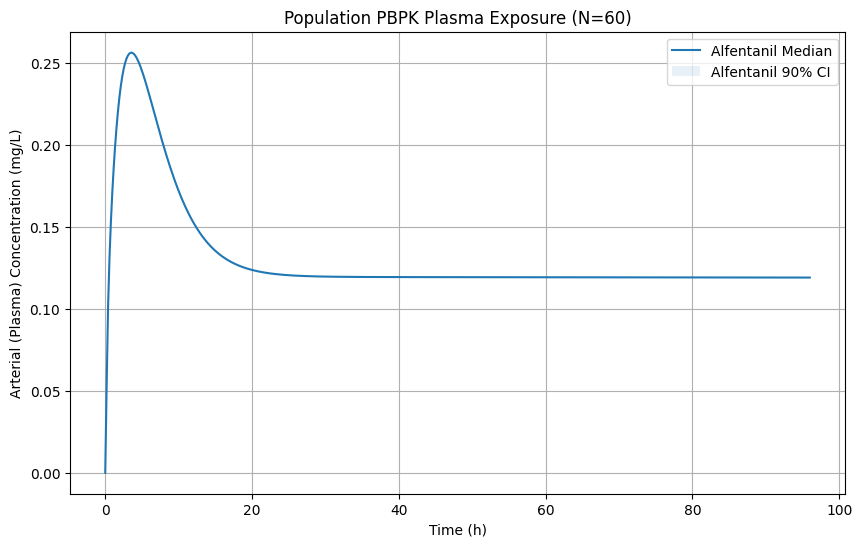


## 📉 Single Individual Plasma Profile (Last Drug)


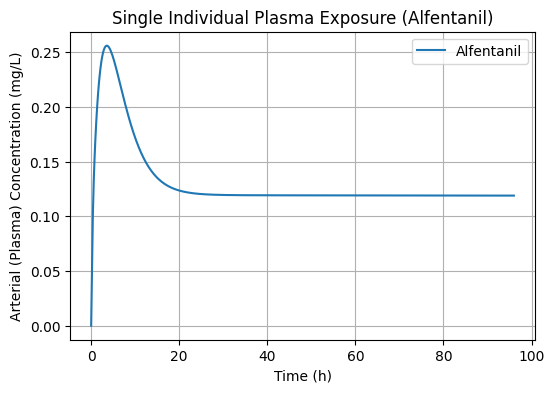

In [24]:
#@title Cell 3: Execution and Results Presentation

# This block executes the model using the parameters defined in Cell 2 and generates the output tables and plots.

final_report_list = []
plasma_profiles_data = {}
single_individual_metrics = []
last_C_art_single = None


# --- Run the Simulation Loop ---
for drug_params in DRUGS_TO_EVALUATE:
    single_res, pop_report_df, Cmax_pop, AUC_pop, t_eval_res, pop_profiles_2d, C_art_single_profile = run_and_evaluate_pbpk(
        drug_params,
        physiology_base,
        t_eval,
        n_individuals=n_pop_indiv
    )

    # Store the single profile for the last drug
    last_C_art_single = C_art_single_profile

    # Store results for table
    single_individual_metrics.append({
        "Drug": single_res['Drug'],
        "Cmax (mg/L)": single_res['Plasma Cmax (mg/L)'],
        "AUC (mg*h/L)": single_res['Plasma AUC (mg*h/L)'],
        "CL_total (L/h)": single_res['CL_total (L/h)'],
        "Tmax (h)": single_res['Tmax (h)'],
        "Hepatic Ext. Ratio": single_res['Hepatic Extraction Ratio'],
        "Type": "Single Individual"
    })

    final_report_list.append(single_res)

    # Combine Single and Population results into one clean table
    pop_report_df.index = pop_report_df['Type']
    pop_report_df = pop_report_df.drop(columns=['Drug', 'Type'])

    single_df = pd.DataFrame([single_individual_metrics[-1]]).set_index('Type')

    combined_summary = pd.concat([single_df, pop_report_df])

    # Store profile data for plotting
    plasma_profiles_data[drug_params["name"]] = {
        'pop_profiles_2d': pop_profiles_2d,
        't_eval': t_eval_res
    }

# --- Results Presentation ---

# 1. Combined Summary Table
print("## 📊 PBPK Simulation Results Summary")
print(f"### Results for: {DRUGS_TO_EVALUATE[-1]['name']}")

print(combined_summary[[
    "Cmax (mg/L)",
    "AUC (mg*h/L)",
    "CL_total (L/h)",
    "Tmax (h)",
    "Hepatic Ext. Ratio",
    "90% CI/GCV%"
]].to_markdown(numalign="left", stralign="left"))


# 2. Population Plot
print("\n## 📈 Population Pharmacokinetic Profile")
plt.figure(figsize=(10, 6))

for drug_name, data in plasma_profiles_data.items():
    pop_profiles_2d = data['pop_profiles_2d']
    t_eval = data['t_eval']

    if pop_profiles_2d.shape[0] > 1:
        median_plasma = np.percentile(pop_profiles_2d, 50, axis=0)
        lower_plasma = np.percentile(pop_profiles_2d, 5, axis=0)
        upper_plasma = np.percentile(pop_profiles_2d, 95, axis=0)

        plt.plot(t_eval, median_plasma, label=f'{drug_name} Median')
        plt.fill_between(t_eval, lower_plasma, upper_plasma, alpha=0.1, label=f'{drug_name} 90% CI')
    else:
        print(f"Warning: {drug_name} has insufficient concentration data for plotting (only {pop_profiles_2d.shape[0]} runs available).")

plt.xlabel("Time (h)")
plt.ylabel("Arterial (Plasma) Concentration (mg/L)")
plt.title(f"Population PBPK Plasma Exposure (N={n_pop_indiv})")
plt.legend()
plt.grid(True)
plt.show()

# 3. Individual Plot (Last Drug)
print("\n## 📉 Single Individual Plasma Profile (Last Drug)")

plt.figure(figsize=(6, 4))
plt.plot(t_eval, last_C_art_single, label=f'{DRUGS_TO_EVALUATE[-1]["name"]}')
plt.xlabel("Time (h)")
plt.ylabel("Arterial (Plasma) Concentration (mg/L)")
plt.title(f"Single Individual Plasma Exposure ({DRUGS_TO_EVALUATE[-1]['name']})")
plt.legend()
plt.grid(True)
plt.show()